# Multicollinearity Analysis, Regularization Techniques, and Spline Modeling in Regression Analysis

In [1]:
# importing necessary packages
import pandas as pd
import numpy as np

import statsmodels.api as sm
import matplotlib.pyplot as plt  
import seaborn as sns  
from scipy import stats  
from statsmodels.stats.diagnostic import het_breuschpagan  
import statsmodels.api as sm  
from statsmodels.formula.api import ols 
from pandas.plotting import scatter_matrix  
from mpl_toolkits.mplot3d import Axes3D  
from scipy import stats  
from scipy.stats import t, f 
from matplotlib.patches import Ellipse 
import statsmodels.stats.diagnostic as diagnostic  
from statsmodels.stats.stattools import durbin_watson  
from statsmodels.graphics.regressionplots import influence_plot 
from statsmodels.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression 
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import itertools  
from collections import OrderedDict  
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Loading and Exploring Dataset

In [2]:
data = pd.read_csv("../STAT4360/multicollinearity_data.csv")
data.head()

,Market_Demand_Index,Consumer_Interest_Index,Distribution_Coverage_Rate,Competitor_Price_Index,Sales_Revenue
0,54.967142,50.186002,40.784858,33.784943,400.484056
1,48.617357,44.877190,37.695136,25.389173,357.715009
2,56.476885,52.995299,45.191996,34.348030,413.850071
3,65.230299,60.814873,52.278200,36.778189,456.482032
4,47.658466,40.137281,37.226642,32.067175,373.337463


In [3]:
# look at data information
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Market_Demand_Index         200 non-null    float64
 1   Consumer_Interest_Index     200 non-null    float64
 2   Distribution_Coverage_Rate  200 non-null    float64
 3   Competitor_Price_Index      200 non-null    float64
 4   Sales_Revenue               200 non-null    float64
dtypes: float64(5)
memory usage: 7.9 KB


,Market_Demand_Index,Consumer_Interest_Index,Distribution_Coverage_Rate,Competitor_Price_Index,Sales_Revenue
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,49.592290,44.804798,39.502522,30.044833,378.721057
std,9.310039,8.789337,7.446573,5.097872,45.137832
min,23.802549,19.459277,21.562436,16.515567,264.104438
25%,42.948723,38.669992,34.117948,26.467654,345.157062
50%,49.958081,45.552636,39.798398,30.111312,379.170377
75%,55.008525,50.006972,44.364578,33.425886,407.177907
max,77.201692,68.796198,64.048861,43.161910,530.555643


In [4]:
# Renaming columns for easier usage
data_1 = data.rename(columns={
    'Market_Demand_Index': 'X1', 
    "Consumer_Interest_Index": "X2", 
    "Distribution_Coverage_Rate": "X3", 
    "Competitor_Price_Index": "X4", 
    "Sales_Revenue": "y"})
data_1.head()

,X1,X2,X3,X4,y
0,54.967142,50.186002,40.784858,33.784943,400.484056
1,48.617357,44.877190,37.695136,25.389173,357.715009
2,56.476885,52.995299,45.191996,34.348030,413.850071
3,65.230299,60.814873,52.278200,36.778189,456.482032
4,47.658466,40.137281,37.226642,32.067175,373.337463


## Exploratory Data Analysis

          X1        X2        X3        X4         y
X1  1.000000  0.974687  0.964368  0.065398  0.948515
X2  0.974687  1.000000  0.938767  0.039572  0.894905
X3  0.964368  0.938767  1.000000  0.093699  0.967219
X4  0.065398  0.039572  0.093699  1.000000  0.279625
y   0.948515  0.894905  0.967219  0.279625  1.000000


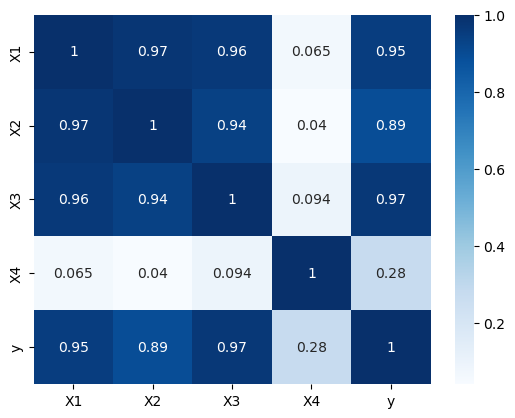

In [5]:
# correlation matrix
correlation_matrix = data_1.corr()

print(correlation_matrix)

sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.show()

*Variables X1, X2, X3 all have high correlations. The only variable that is not correlated with the other variables is X4.*

## Fitting Regression model

In [6]:
model = ols('y~X1+X2+X3+X4',data = data_1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4508.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          7.03e-191
Time:                        17:04:45   Log-Likelihood:                -591.46
No. Observations:                 200   AIC:                             1193.
Df Residuals:                     195   BIC:                             1209.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     96.9309      2.596     37.341      0.0

*All the variables appear to be statistically significant in predicting the sales revenue*

**Checking for VIF**

In [7]:
X = data_1[['X1','X2','X3','X4']]
y = data_1['y']
X_with_const = add_constant(X)

vif = pd.DataFrame()
vif["Predictor"] = X_with_const.columns
vif["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]

vif = vif[vif["Predictor"] != 'const']

vif = vif.sort_values(by="VIF", ascending=False)

print(vif)


  Predictor        VIF
1        X1  33.959159
2        X2  20.244978
3        X3  14.482652
4        X4   1.029735


*When checking the VIF scores we can see there is a multicollinearity issue with variables X1, X2, X3. That is because if their VIF score is greater than 10 then it shows multicollinearity.*

## Fitting other type of models

*To deal with multicollinearity we can fit a ridge, lasso, and a PCR model*

**Ridge**

In [8]:
model = sm.OLS(y, X_with_const)
ols_model = model.fit()
alpha=np.array([0, 0.5, 0.5, 0.5, 0.5])
ridge_model = model.fit_regularized(L1_wt=0, alpha=alpha, start_params=ols_model.params)
final = sm.regression.linear_model.OLSResults(model, ridge_model.params, ols_model.normalized_cov_params)
print(final.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     4181.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          9.92e-188
Time:                        17:10:46   Log-Likelihood:                -598.90
No. Observations:                 200   AIC:                             1208.
Df Residuals:                     195   BIC:                             1224.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         98.4882      2.694     36.555      0.0

*The ridge model with alpha values=0.5 has a R^2 score of 98.8% meaning that it explains the variance of the sales revenue very well. Also, we can observe that all variables are statistically significant in predicting sales revenue since p-value smaller than .05. In addition, we can see that variables X3 and X1 have the greatest influence on the sales revenue since they both have the highest magnitude.*

**Lasso**

In [9]:
X_const = sm.add_constant(X)

alphas = np.linspace(-1, 1.0, 20)

best_alpha = None
best_mse = float('inf')  # Initialize the best MSE to a large number
best_lasso_model = None  # Store the best Lasso model

# Loop through each alpha value and fit the Lasso model
for alpha_value in alphas:
    # Set up the alpha array with 0 for intercept, same alpha for other features
    alpha = np.array([0] + [alpha_value] * (X_const.shape[1] - 1))
    
    # Fit the Lasso model (L1_wt=1 means Lasso)
    lasso_model = sm.OLS(y, X_const).fit_regularized(L1_wt=1, alpha=alpha)
    
    final_lasso = sm.regression.linear_model.OLSResults(sm.OLS(y, X_const), 
                                                        lasso_model.params, 
                                                        ols_model.normalized_cov_params)
    
    # Calculate Mean Squared Error (MSE) as the evaluation metric
    predictions = final_lasso.predict(X_const)
    mse = mean_squared_error(y, predictions)
    
    # Track the best model based on the lowest MSE
    if mse < best_mse:
        best_mse = mse
        best_alpha = alpha_value
        best_lasso_model = final_lasso

# Print the best alpha and the summary of the best model
print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {best_mse}")
print(best_lasso_model.summary())


Best alpha: 1.0
Best MSE: 387.8463563631126
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     206.1
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           7.47e-69
Time:                        17:12:37   Log-Likelihood:                -879.85
No. Observations:                 200   AIC:                             1770.
Df Residuals:                     195   BIC:                             1786.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const   

**Principle Component Regression**

In [10]:
# 1. standardize the features X (without intercept)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. PCA reduction dimensions
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 3. compute eignevalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

print("eigenvalues:", eigenvalues)
print('__________________________________________________')
print("eigenvectors:\n", eigenvectors)
print('__________________________________________________')

# 4. choose the numbers of PC
X_pca = X_pca[:, :2]

# 5. statsmodels does regression model now 
model = sm.OLS(y, sm.add_constant(X_pca))
results = model.fit()
print(results.summary())


eigenvalues: [2.94015469 0.99975441 0.06080459 0.01938681]
__________________________________________________
eigenvectors:
 [[ 0.58037426  0.57477947  0.5738119   0.05944891]
 [-0.03604313 -0.06250016 -0.00427166  0.99738477]
 [-0.1152318  -0.63821894  0.76008238 -0.04090226]
 [-0.80534976  0.50832949  0.30495317  0.00405662]]
__________________________________________________
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     1861.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          1.22e-128
Time:                        17:16:55   Log-Likelihood:                -746.21
No. Observations:                 200   AIC:                             1498.
Df Residuals:                     197   BIC:                      

## Loading and Exploring Dataset

In [12]:
df = pd.read_csv("../STAT4360/spline_data.csv")
df.head()

,x,y
0,0.005522,0.067753
1,0.020584,0.189849
2,0.025419,0.280284
3,0.034389,0.167189
4,0.045227,0.457573


In [13]:
x = df['x']
y = df['y']

In [14]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       100 non-null    float64
 1   y       100 non-null    float64
dtypes: float64(2)
memory usage: 1.7 KB


,x,y
count,100.000000,100.000000
mean,0.470181,0.439341
std,0.297489,1.099069
min,0.005522,-1.167876
25%,0.193201,-0.550541
50%,0.464142,0.403987
75%,0.730203,1.516609
max,0.986887,2.224635


## Fitting model

In [15]:
ols_model = ols('y~x',data=df).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.534
Method:                 Least Squares   F-statistic:                     114.6
Date:                Thu, 16 Jan 2025   Prob (F-statistic):           3.56e-18
Time:                        17:21:48   Log-Likelihood:                -112.11
No. Observations:                 100   AIC:                             228.2
Df Residuals:                      98   BIC:                             233.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7148      0.141     12.182      0.0

In [16]:
fitted_values = ols_model.fittedvalues

residuals = ols_model.resid

## Exploratory Data Analysis

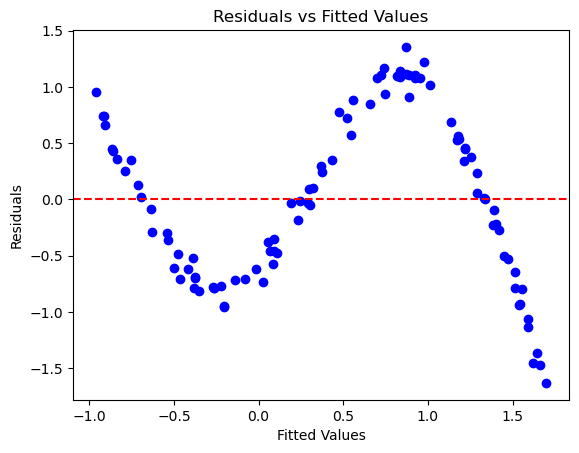

In [17]:
# Plot: Residuals vs Fitted values
plt.scatter(fitted_values, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')  
plt.title("Residuals vs Fitted Values")
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


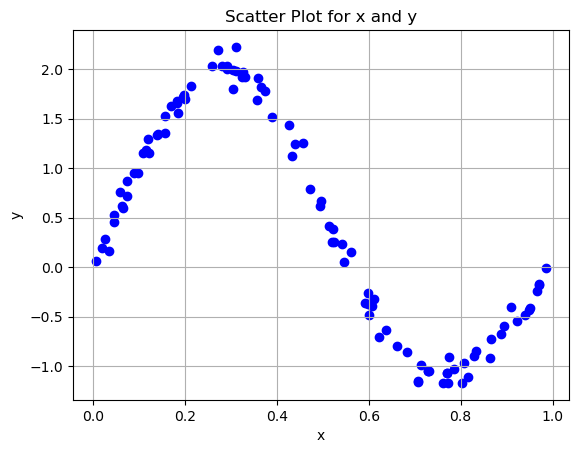

In [18]:
plt.scatter(x,y,color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot for x and y')
plt.grid(True)
plt.show()

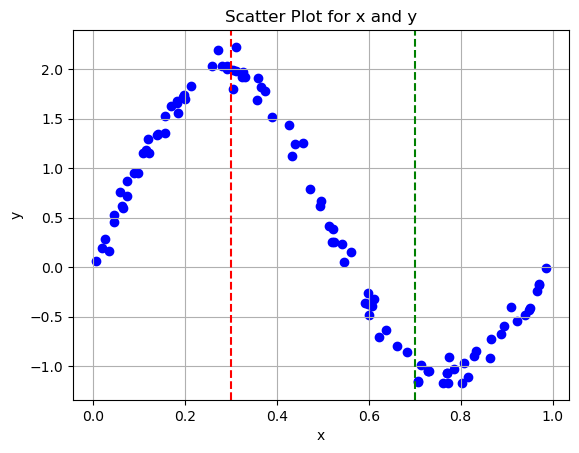

In [19]:
plt.scatter(x,y,color='blue')
plt.axvline(x=.3, color='red', linestyle='--', label='x=.3')
plt.axvline(x=.7, color='green', linestyle='--', label='x=.7')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot for x and y')
plt.grid(True)
plt.show()

*A common way to know where and how many knots you will set up is by looking at the predictor and target variables. The area where the relationship between the predictor and target variable changes is usually where a knot should be. We can see that for this data the knots would be around .3 and .7.*

## Running a Cubic Model with the two knots

In [20]:
df['x^2']=df['x']**2
df['x^3']=df['x']**3

def cubic_spline(x,knot):
    return np.where(x > knot, (x-knot)**3,0)

df['basis1'] = cubic_spline(x,.3)
df['basis2'] = cubic_spline(x,.7)

df.head()

,x,y,x^2,x^3,basis1,basis2
0,0.005522,0.067753,0.000030,1.683902e-07,0.0,0.0
1,0.020584,0.189849,0.000424,8.722091e-06,0.0,0.0
2,0.025419,0.280284,0.000646,1.642411e-05,0.0,0.0
3,0.034389,0.167189,0.001183,4.066685e-05,0.0,0.0
4,0.045227,0.457573,0.002046,9.251277e-05,0.0,0.0


In [21]:
x_cubic_spline = df[['x','x^2','x^3','basis1','basis2']]
x_cubic_spline = sm.add_constant (x_cubic_spline)

model = sm.OLS(y,x_cubic_spline).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2781.
Date:                Thu, 16 Jan 2025   Prob (F-statistic):          1.86e-100
Time:                        17:24:29   Log-Likelihood:                 99.330
No. Observations:                 100   AIC:                            -186.7
Df Residuals:                      94   BIC:                            -171.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.053      0.036      0.9

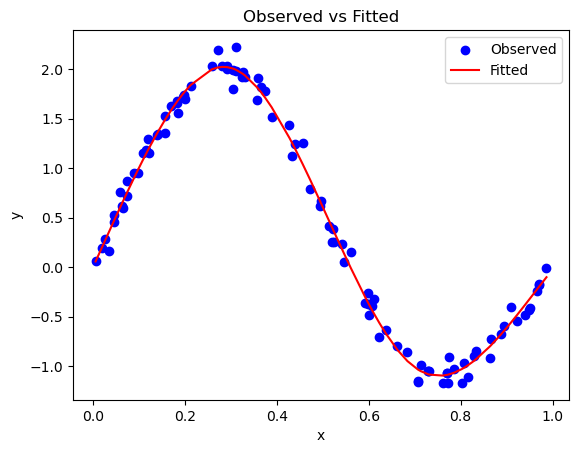

In [22]:
fitted_values = model.fittedvalues

residuals = model.resid

plt.scatter(df['x'], df['y'], label="Observed", color="blue")
plt.plot(df['x'], fitted_values, label="Fitted", color="red")
plt.title("Observed vs Fitted")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


## Residuals of the cubic spline model

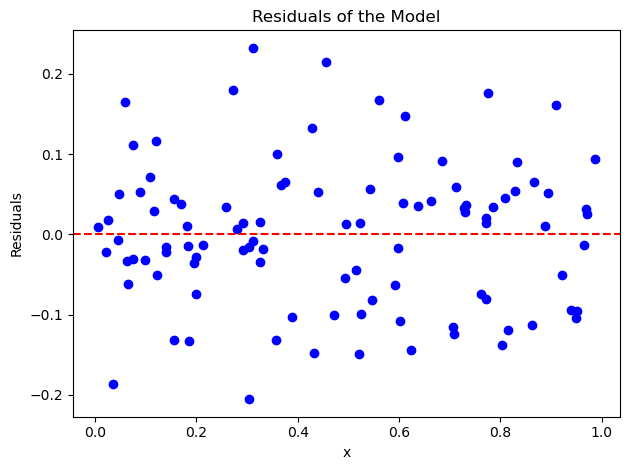

In [23]:
plt.scatter(df['x'], residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')  # Zero line for reference
plt.title("Residuals of the Model")
plt.xlabel('x')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


*We can see that the residuals now act normal and have constant variance*